Legend: </br>
- comments with a single '#' has description of the cell on what its doing
- comments with double '##' has reasoning and other conclusions

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# read csv file
df = pd.read_csv("/content/acquisition_train.csv")

## EDA : Exploratory data analysis

In [3]:
# visualize some rows
df.head()

## some confidential row values are hashed and column names are given generic values due to privacy

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


In [4]:
# data frame shape
print('Number of rows: ', df.shape[0])
print('Number of columns: ', df.shape[1])

Number of rows:  45000
Number of columns:  43


In [5]:
# percentage of missing values per feature
print((df.isnull().sum() * 100 / df.shape[0]).sort_values(ascending=False))

## drop columns with 40% missing values as they cannot be regenerated with good accuracy

target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

In [6]:
# number of unique observations per column
df.nunique().sort_values()

## drop columsn with just a single unique value, it has 0 variance and cannot be used for classifying

external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts    

## Data Preprocessing

In [7]:
# drop columns with above mentioned faults and also drop columns which are not helpful, for clustering/classifying, ex: email id, phone number etc
# and remove which are completely random, ex hashed values, score_1, score_2
df.drop(labels=['target_fraud', 'last_amount_borrowed', 'last_borrowed_in_months', 'ok_since', 'external_data_provider_credit_checks_last_2_year',
                'external_data_provider_credit_checks_last_2_year', 'channel',
                'email', 'reason', 'zip', 'job_name', 'external_data_provider_first_name', 'lat_lon',
                'facebook_profile',
                'shipping_zip_code', 'user_agent', 'profile_tags', 'marketing_channel',
                'profile_phone_number', 'application_time_applied', 'ids', 'shipping_state',
                'application_time_in_funnel', 'external_data_provider_email_seen_before',
                'external_data_provider_credit_checks_last_month', 'external_data_provider_credit_checks_last_year',
                'score_1', 'score_2', 'state', 'real_state'], axis=1, inplace=True)
     

In [8]:
df.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,external_data_provider_fraud_score,reported_income
0,False,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,0.0,0.0,18.0,18.0,645,57849.0
1,False,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,0.0,0.0,14.0,14.0,243,4902.0
2,True,360.0,100.027073,0.351918,112.892453,0.29,NaN,65023.65,0.0,0.0,10.0,NaN,65,163679.0
3,False,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,1.0,0.0,19.0,19.0,815,1086.0
4,False,500.0,98.474289,0.532539,118.126207,0.18,NaN,60011.29,0.0,0.0,11.0,NaN,320,198618.0


In [9]:
df.describe()

## reported income has an undefined inf value

,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,external_data_provider_fraud_score,reported_income
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,31200.000000,4.443800e+04,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,45000.00
mean,347.983258,100.006797,0.500037,99.925228,0.296717,34381.951154,7.160739e+04,0.076270,0.004569,10.696701,11.068119,500.399800,inf
std,110.429165,3.178080,0.288326,10.016549,0.101933,36586.982218,5.185897e+04,0.274052,0.079400,4.592463,4.595501,287.968873,NaN
min,0.000000,86.191572,0.000035,60.663039,0.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,403.00
25%,270.000000,97.867036,0.252150,93.198353,0.220000,10000.000000,4.501078e+04,0.000000,0.000000,7.000000,8.000000,252.000000,50948.25
50%,340.000000,100.018900,0.500753,99.974796,0.290000,25647.000000,6.126676e+04,0.000000,0.000000,10.000000,10.000000,503.000000,101779.00
75%,420.000000,102.141797,0.748816,106.640275,0.360000,47086.750000,8.601923e+04,0.000000,0.000000,13.000000,14.000000,747.000000,151337.25
max,990.000000,113.978234,0.999973,142.192400,0.900000,448269.000000,5.000028e+06,5.000000,5.000000,49.000000,49.000000,1000.000000,inf


Score 3 goes from 0-990, can be assumed to be the CIBIL score or a metric similar to it

In [10]:
# replace "inf" values with "nan"
df['reported_income'] = df['reported_income'].replace(np.inf, np.nan)

In [11]:
len(df.columns)

14

In [12]:
df.columns

Index(['target_default', 'score_3', 'score_4', 'score_5', 'score_6',
       'risk_rate', 'credit_limit', 'income', 'n_bankruptcies',
       'n_defaulted_loans', 'n_accounts', 'n_issues',
       'external_data_provider_fraud_score', 'reported_income'],
      dtype='object')

Replace missing values using an imputer, here we use k means imputer to approximate the missing vales

In [13]:
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(df)
# transform the dataset
Xtrans = imputer.transform(df)

In [14]:
# numpy to dataframe
df_trans = pd.DataFrame(Xtrans, columns=df.columns)

Its important to scale the data to remove any kind of bias due to value ranges, features with value ranging from 0-100 and 1000-10000 must be treated equally and scaling the data to have zero norm is one way (shown below)

In [15]:
# scaling the input
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()

X_trans = ms.fit_transform(Xtrans)

## Data visualisation

Text(0.5, 1.0, 'Correlation Heatmap')

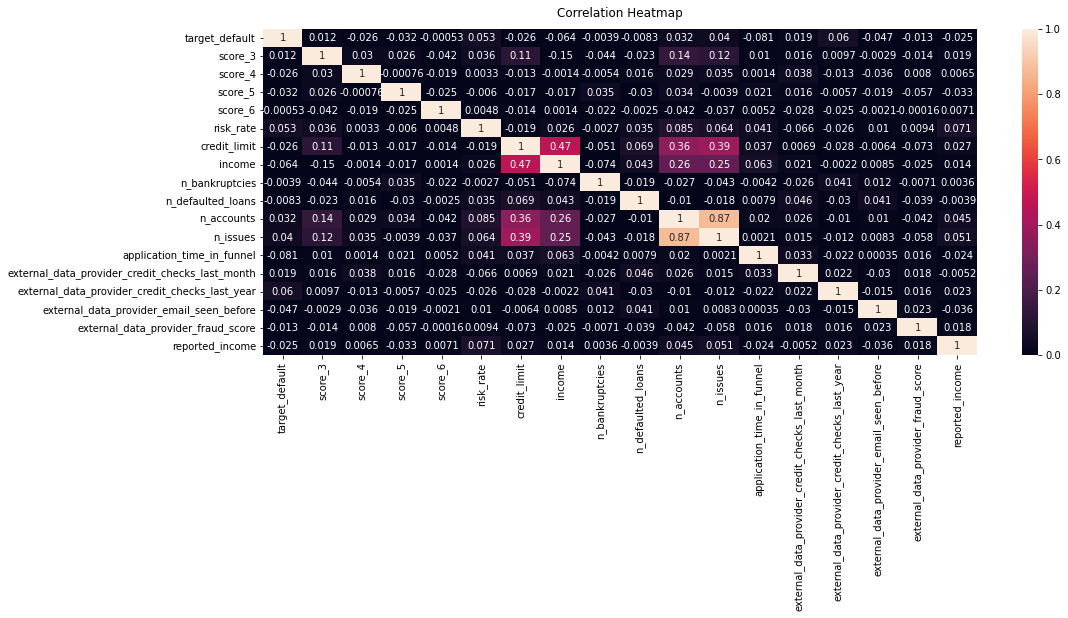

In [14]:
# heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_trans.corr(), vmin= 0, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

## not much correlation found

We dont find any correlation which helps us directy evaluate the dependent variable target_default directly, only significant correlations are number of accounts, credit limit, income etc which are by default correlated as a person with higher income will have higher credit limit and also has higher chances of having more than one account due to more transactions.

## Clustering

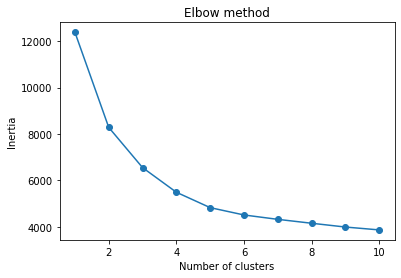

In [28]:
# finding number of clusters using elbow method
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_trans)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

We see that after 5 clusters approximately there is a gradual decrease rather than a sharp decrease as seen in lesser clusters, so we can start with 5 clusters

Clusters - 5

In [28]:
# clustering using k means
kmeans = KMeans(n_clusters= 5)
label = kmeans.fit_predict(X_trans)
df_trans['label'] = label

Text(0.5, 1.0, 'Correlation Heatmap')

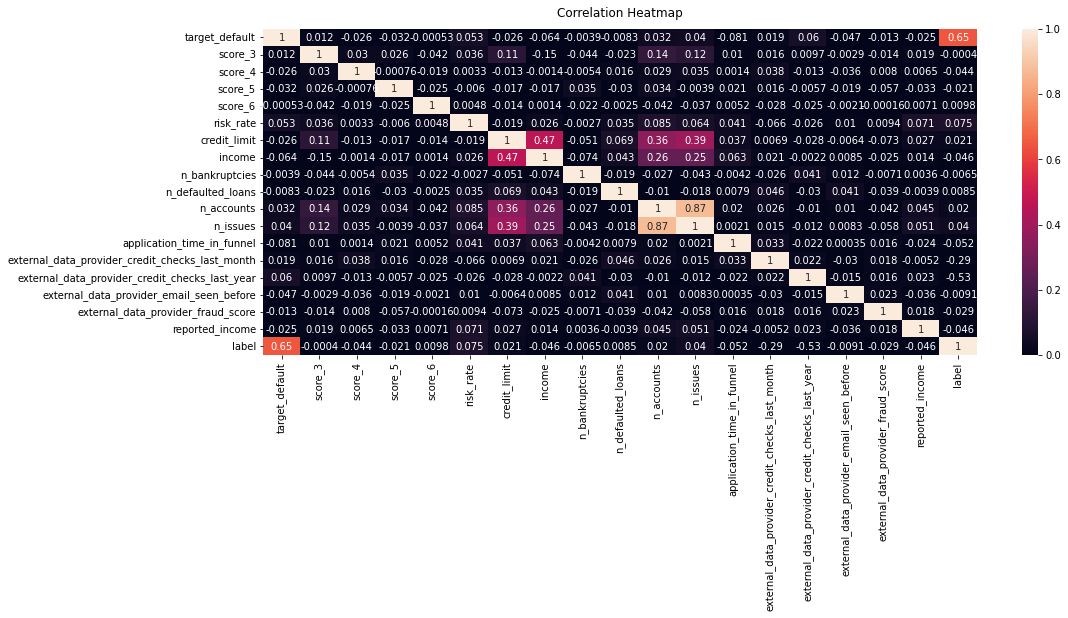

In [17]:
# heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_trans.corr(), vmin= 0, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

## high correlation bw label and default probabilty(target_default)

In [18]:
# Example 2: create multiple columns of stacked bar plot
# df_trans.plot(kind="bar", stacked = True)

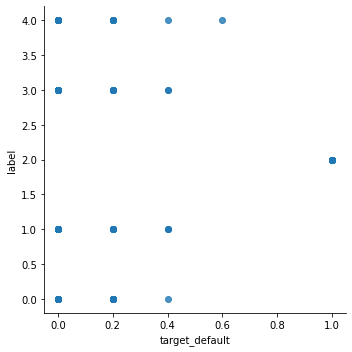

In [30]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="target_default", y="label", data=df_trans, fit_reg=False, legend=True)
plt.show()

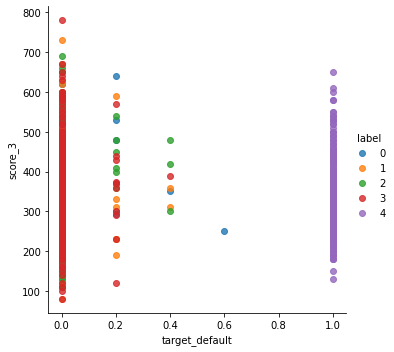

In [19]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="target_default", y="score_3", data=df_trans, fit_reg=False, hue='label', legend=True)
plt.show()

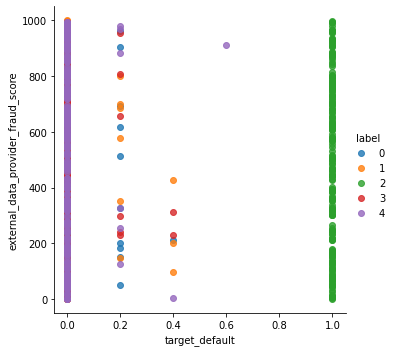

In [29]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="target_default", y="external_data_provider_fraud_score", data=df_trans, fit_reg=False, hue='label', legend=True)
plt.show()

- As we can see that there are two prominent clusters being formed, one with higher probability of defaulting (cluster 4) and one with lower probability of defaulting (cluster 3). 
- We can thus reduce the clusters to 3 or 2 to get a cleaner view of the clusters, as the remaining 3 clusters seem to be random

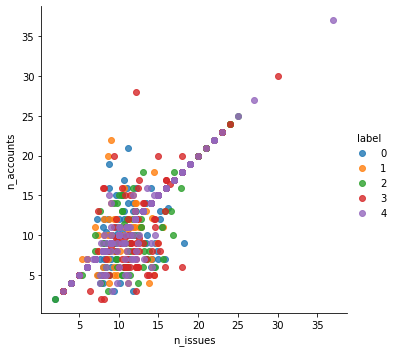

In [20]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="n_issues", y="n_accounts", data=df_trans, fit_reg=False, hue='label', legend=True)
plt.show()

Clusters - 3

In [16]:
kmeans = KMeans(n_clusters= 3)
label = kmeans.fit_predict(X_trans)
df_trans['label'] = label

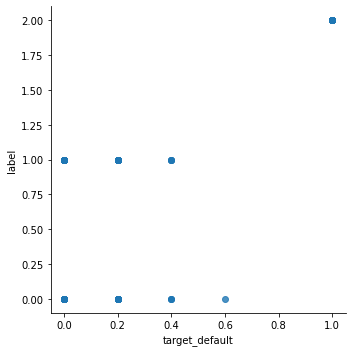

In [26]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="target_default", y="label", data=df_trans, fit_reg=False, legend=True)
plt.show()

## high risk defaulters have a different cluster than low and medium risk defaulters

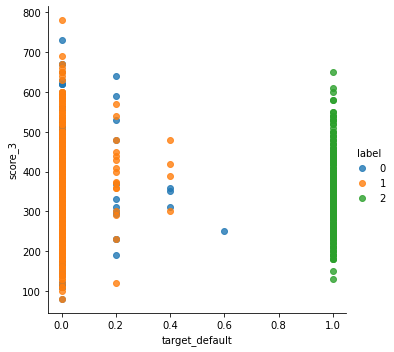

In [22]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="target_default", y="score_3", data=df_trans, fit_reg=False, hue='label', legend=True)
plt.show()

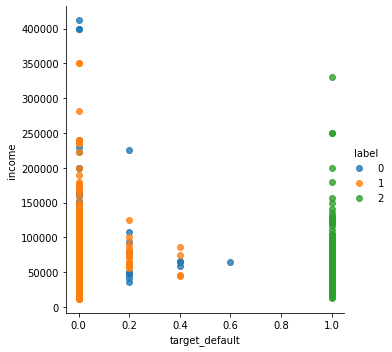

In [23]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="target_default", y="income", data=df_trans, fit_reg=False, hue='label', legend=True)
plt.show()

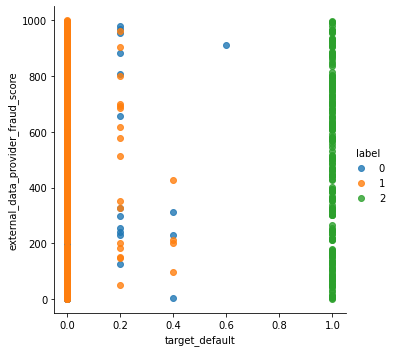

In [25]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="target_default", y="external_data_provider_fraud_score", data=df_trans, fit_reg=False, hue='label', legend=True)
plt.show()

The external data provided by other agencies on whether a person will default, perfectly coincides with our clustering with low and high defaulters distinctly classified

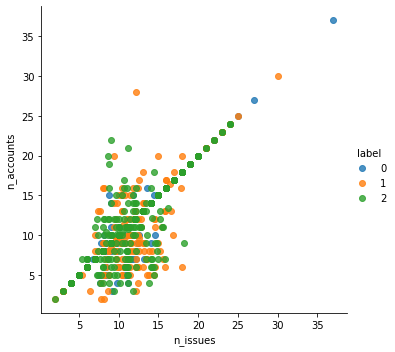

In [32]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="n_issues", y="n_accounts", data=df_trans, fit_reg=False, hue='label', legend=True)
plt.show()

## Data Interpretation

In [17]:
# we will sample subset of the actual dataframe, due to limitations in ram size
df = df_trans.sample(frac=0.20)

In [18]:
## downcasting loop, reduces dataframe size
for column in df:
 if df[column].dtype == 'float64':
  df[column] = pd.to_numeric(df[column], downcast='float')
 if df[column].dtype == 'int64':
  df[column] = pd.to_numeric(df[column], downcast='integer')

In [ ]:
# g = sns.PairGrid(df, hue="label")
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()

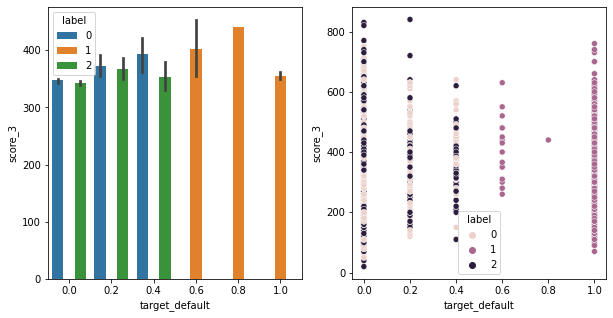

In [27]:
# insights using target default and score 3 (cibil score)
fig, axs = plt.subplots(ncols=2)
fig.set_figheight(5)
fig.set_figwidth(10)
sns.barplot(data=df, x="target_default", y = "score_3", hue="label", ax=axs[0])
sns.scatterplot(data=df, x="target_default", y = "score_3", hue="label", ax=axs[1])

- We can see that we can easily separate high risk defaulters from the lower risk ones using our clustering techniques
- Higher risk ones have cluster 1 and lower risk are cluster 0 and 2

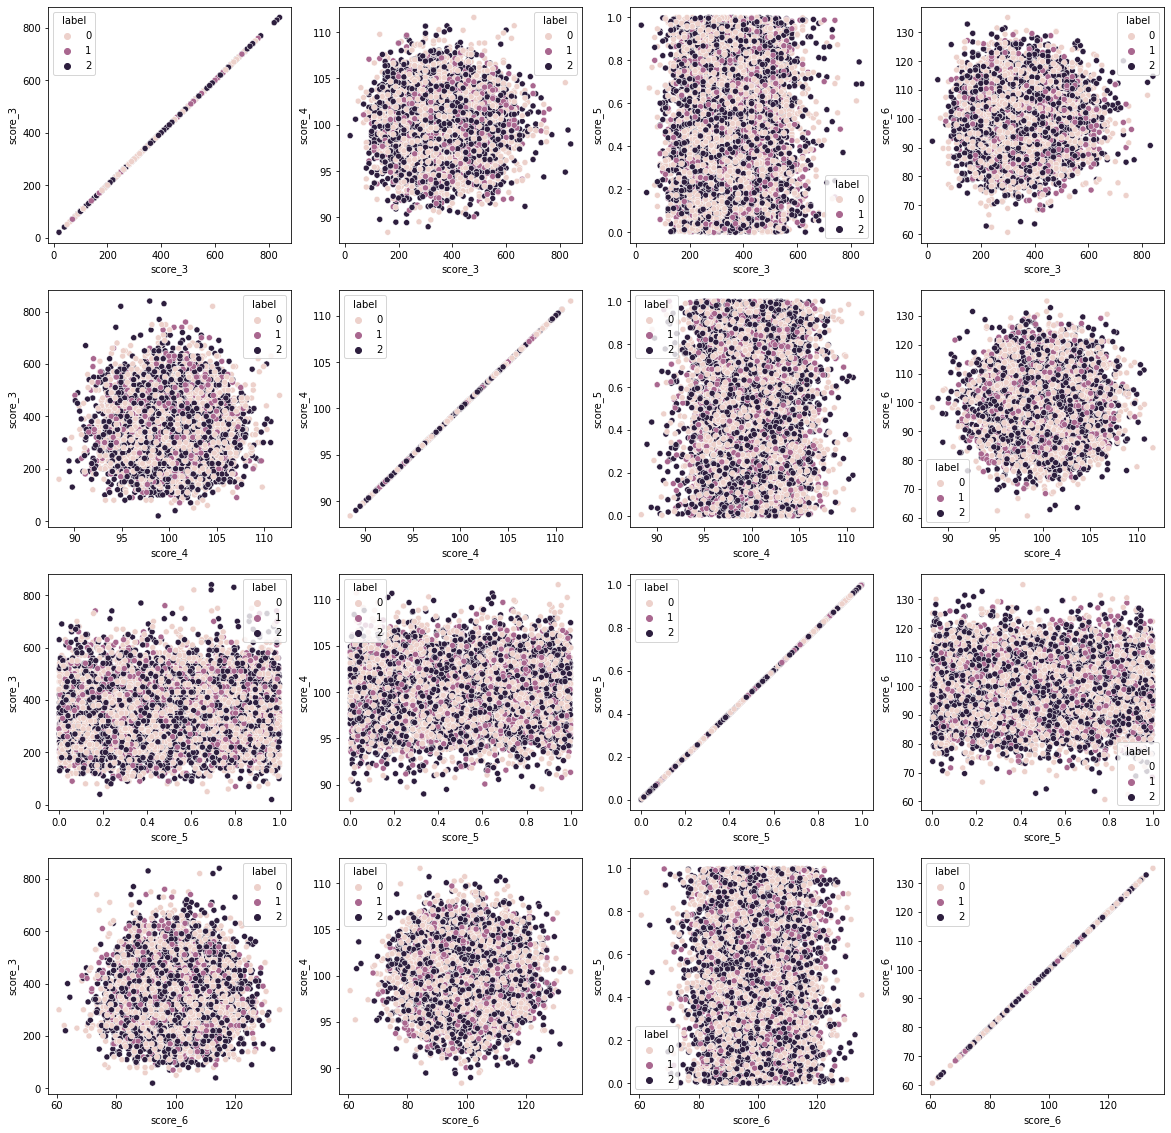

In [25]:
scores = ['score_3', 'score_4', 'score_5', 'score_6']
fig, axs = plt.subplots(ncols=4,nrows=4)
fig.set_figheight(20)
fig.set_figwidth(20)
for i,score1 in enumerate(scores):
  for j,score2 in enumerate(scores):
    sns.scatterplot(data=df, x = score1, y = score2, hue="label", ax=axs[i][j])

We can see that the score and clustering are even distributed and we can interpret nothing more than we have already concluded